In [1]:
import torch,os,pickle,math,evaluate,nltk
from nltk.translate.meteor_score import single_meteor_score
from nltk.translate.nist_score import sentence_nist
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from collections import Counter
from evaluate import load,logging
import pandas as pd
from transformers import BitsAndBytesConfig,LlamaTokenizer,LlamaForCausalLM,GPT2Tokenizer, GPT2LMHeadModel
from bert_evaluation import Model,get_accuracy_by_bert
import numpy as np
from torch.nn import CrossEntropyLoss
from utils.performance_eval import result_per_setting
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = 'cuda'
import matplotlib.pyplot as plt
import numpy as np



In [2]:
model_path ="meta-llama/Llama-2-7b-chat-hf"
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)
modelsss =LlamaForCausalLM.from_pretrained(pretrained_model_name_or_path = model_path,
                                    #load_in_8bit=True, #  7.7GB로
                                        quantization_config =nf4_config, #  4.4GB로 
                                        device_map="auto", # gpu 꽉차면 cpu로 올려줌 
                                        
                                       )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
old_columns=['acc','recall','precision','f1','class_pr','METEOR','D-1','D-2','D-3','N-2',
             'N-4','BLEU1','BLEU2','RougeL','Entropy2', 'Entropy4','Perplexity']
empty_df = pd.DataFrame(columns =old_columns)
setting_name = '{}__{}__{}'.format(0,0,0)
retab = result_per_setting(setting_name,device,modelsss)

new_columns=['acc','recall','precision','f1','class_pr','Perplexity','METEOR','D-1','D-2','D-3','N-2',
             'N-4','BLEU1','BLEU2','RougeL','Entropy2', 'Entropy4']
not_perturb = pd.concat([empty_df, retab])[new_columns]
not_perturb

valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.49it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0__0__0,0.614,0.614,0.626,0.604,0.389,9.21,17.33,20.36,65.79,87.17,0.39,0.39,9.56,1.13,8.0,6.58,7.28


## num_iter 3
### table 1. 
- pre-trained 
- 0.01_100_3
- ...
- 0.5_100
### table 2~15
- 0.01_100_3
- 0.01_11_3
- 0.01_22_3
- 0.01_32_3

### table 2~15 평균

### num_iter 5


In [4]:
#table1


def df_create(stepsizess, perturb_layers,num_iterationsss):
    empty_df = pd.DataFrame(columns =old_columns)
    for stepsize in stepsizess:
        for num_iterations in num_iterationsss:
            for perturb_layer in perturb_layers:
                setting_name = '{}__{}__{}'.format(stepsize,perturb_layer,num_iterations)
                retab = result_per_setting(setting_name,device,modelsss)
                empty_df= pd.concat([empty_df, retab])

    empty_df = empty_df[new_columns]
    return empty_df

stepsizess = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
df_100_3 = df_create(stepsizess,[100],[3])
df_100_5 = df_create(stepsizess,[100],[5])


#empty_df_3= empty_df_3.drop(['0.06__100__3','0.04__100__3','0.08__100__3'])


valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.33it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.13it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.91it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.06it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.73it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.05it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.11it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.68it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.16it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.93it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.32it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.70it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.86it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.68it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.25it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.61it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.59it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.45it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.06it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.93it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
df_100_35 = df_100_3.reset_index(drop=True).add(df_100_5.reset_index(drop=True)) /2

In [6]:
display(df_100_3)
display(df_100_5)
display(df_100_35)

,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.01__100__3,0.568,0.568,0.558,0.547,0.342,11.46,18.2,19.57,64.07,85.95,0.48,0.48,10.63,1.64,10.31,6.57,7.32
0.02__100__3,0.636,0.636,0.659,0.609,0.35,9.02,17.13,19.32,64.49,86.24,0.42,0.42,9.63,1.46,8.95,6.61,7.33
0.03__100__3,0.659,0.659,0.702,0.647,0.422,11.62,18.88,21.26,66.05,86.53,0.49,0.49,10.28,1.87,10.29,6.53,7.22
0.04__100__3,0.682,0.682,0.69,0.662,0.387,9.54,17.76,19.77,65.02,86.52,0.45,0.45,9.94,1.39,8.34,6.58,7.3
0.05__100__3,0.705,0.705,0.729,0.699,0.402,11.62,17.43,19.84,64.03,86.35,0.4,0.4,9.58,0.98,7.76,6.6,7.34
0.06__100__3,0.591,0.591,0.637,0.564,0.403,13.03,21.27,20.18,64.36,86.12,0.47,0.47,10.56,1.45,9.63,6.54,7.27
0.07__100__3,0.568,0.568,0.658,0.555,0.352,10.74,17.48,19.53,64.03,86.06,0.42,0.42,9.55,0.74,8.47,6.6,7.34
0.08__100__3,0.659,0.659,0.702,0.658,0.406,14.86,18.62,20.35,64.6,85.78,0.43,0.43,9.85,1.3,9.3,6.55,7.27
0.09__100__3,0.659,0.659,0.669,0.652,0.429,11.92,19.25,19.91,63.59,85.47,0.42,0.42,9.78,1.37,8.65,6.54,7.27
0.1__100__3,0.614,0.614,0.607,0.584,0.365,14.73,17.68,20.25,65.75,88.04,0.43,0.43,9.9,1.04,9.75,6.58,7.3


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.01__100__5,0.682,0.682,0.755,0.672,0.424,11.01,20.36,21.27,65.97,86.68,0.46,0.46,10.4,1.16,9.98,6.52,7.21
0.02__100__5,0.705,0.705,0.739,0.697,0.427,10.62,18.42,20.93,65.59,86.23,0.44,0.44,9.26,1.58,8.58,6.53,7.22
0.03__100__5,0.659,0.659,0.663,0.638,0.413,11.66,17.7,20.86,65.31,86.64,0.41,0.41,10.08,1.11,9.36,6.57,7.28
0.04__100__5,0.636,0.636,0.673,0.621,0.415,10.52,19.95,19.5,63.65,85.96,0.47,0.47,10.03,1.42,10.31,6.59,7.35
0.05__100__5,0.591,0.591,0.588,0.574,0.411,19.38,16.55,20.6,65.71,87.18,0.4,0.4,9.88,0.71,8.2,6.57,7.27
0.06__100__5,0.545,0.545,0.59,0.526,0.372,13.36,16.71,20.28,64.24,85.55,0.42,0.42,8.94,0.94,8.19,6.54,7.27
0.07__100__5,0.659,0.659,0.695,0.655,0.427,21.9,17.86,20.34,65.14,86.63,0.43,0.43,9.95,1.42,9.63,6.59,7.31
0.08__100__5,0.705,0.705,0.742,0.674,0.412,18.2,16.32,21.08,66.52,87.19,0.42,0.42,9.63,1.19,8.71,6.53,7.22
0.09__100__5,0.614,0.614,0.647,0.597,0.415,11.67,17.43,21.51,65.78,87.6,0.43,0.43,9.8,1.34,8.98,6.53,7.24
0.1__100__5,0.636,0.636,0.66,0.606,0.383,19.29,16.0,19.19,63.71,85.77,0.36,0.36,8.89,0.96,7.57,6.61,7.35


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.625,0.625,0.6565,0.6095,0.383,11.235,19.28,20.42,65.02,86.315,0.47,0.47,10.515,1.4,10.145,6.545,7.265
1,0.6705,0.6705,0.699,0.653,0.3885,9.82,17.775,20.125,65.04,86.235,0.43,0.43,9.445,1.52,8.765,6.57,7.275
2,0.659,0.659,0.6825,0.6425,0.4175,11.64,18.29,21.06,65.68,86.585,0.45,0.45,10.18,1.49,9.825,6.55,7.25
3,0.659,0.659,0.6815,0.6415,0.401,10.03,18.855,19.635,64.335,86.24,0.46,0.46,9.985,1.405,9.325,6.585,7.325
4,0.648,0.648,0.6585,0.6365,0.4065,15.5,16.99,20.22,64.87,86.765,0.4,0.4,9.73,0.845,7.98,6.585,7.305
5,0.568,0.568,0.6135,0.545,0.3875,13.195,18.99,20.23,64.3,85.835,0.445,0.445,9.75,1.195,8.91,6.54,7.27
6,0.6135,0.6135,0.6765,0.605,0.3895,16.32,17.67,19.935,64.585,86.345,0.425,0.425,9.75,1.08,9.05,6.595,7.325
7,0.682,0.682,0.722,0.666,0.409,16.53,17.47,20.715,65.56,86.485,0.425,0.425,9.74,1.245,9.005,6.54,7.245
8,0.6365,0.6365,0.658,0.6245,0.422,11.795,18.34,20.71,64.685,86.535,0.425,0.425,9.79,1.355,8.815,6.535,7.255
9,0.625,0.625,0.6335,0.595,0.374,17.01,16.84,19.72,64.73,86.905,0.395,0.395,9.395,1.0,8.66,6.595,7.325


In [7]:
df_01_per_step_3 = df_create([0.01],[100,11,22,32],[3])
df_02_per_step_3 = df_create([0.02],[100,11,22,32],[3])
df_03_per_step_3 = df_create([0.03],[100,11,22,32],[3])
df_04_per_step_3 = df_create([0.04],[100,11,22,32],[3])
df_05_per_step_3 = df_create([0.05],[100,11,22,32],[3])
df_06_per_step_3 = df_create([0.06],[100,11,22,32],[3])
df_07_per_step_3 = df_create([0.07],[100,11,22,32],[3])
df_08_per_step_3 = df_create([0.08],[100,11,22,32],[3])
df_09_per_step_3 = df_create([0.09],[100,11,22,32],[3])
df_10_per_step_3 = df_create([0.1],[100,11,22,32],[3])
df_01_per_step_5 = df_create([0.01],[100,11,22,32],[5])
df_02_per_step_5 = df_create([0.02],[100,11,22,32],[5])
df_03_per_step_5 = df_create([0.03],[100,11,22,32],[5])
df_04_per_step_5 = df_create([0.04],[100,11,22,32],[5])
df_05_per_step_5 = df_create([0.05],[100,11,22,32],[5])
df_06_per_step_5 = df_create([0.06],[100,11,22,32],[5])
df_07_per_step_5 = df_create([0.07],[100,11,22,32],[5])
df_08_per_step_5 = df_create([0.08],[100,11,22,32],[5])
df_09_per_step_5 = df_create([0.09],[100,11,22,32],[5])
df_10_per_step_5 = df_create([0.1],[100,11,22,32],[5])

valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.81it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.84it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.60it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.65it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.08it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.62it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.41it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.98it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.48it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.19it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.49it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.24it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.57it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.38it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.87it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.69it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.85it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.51it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.71it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.76it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.14it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.33it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.07it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.28it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.72it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.82it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.33it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.42it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 18.97it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.38it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.80it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.78it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.51it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.76it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.03it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.08it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.63it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.02it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.14it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.07it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.80it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.52it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.46it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.55it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.99it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.13it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.56it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.06it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.89it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.34it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.13it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.23it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.69it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.78it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.45it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.21it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.91it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.86it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.84it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.82it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.47it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.42it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.91it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.42it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.99it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.15it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 24.81it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.66it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.44it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.79it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 20.50it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.97it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.75it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.63it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.94it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 23.51it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.01it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 22.26it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 25.24it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.00it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/wooseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/wooseok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/wooseok/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
df_01_35 = df_01_per_step_3.reset_index(drop=True).add(df_01_per_step_5.reset_index(drop=True)) /2
df_02_35 = df_02_per_step_3.reset_index(drop=True).add(df_02_per_step_5.reset_index(drop=True)) /2
df_03_35 = df_03_per_step_3.reset_index(drop=True).add(df_03_per_step_5.reset_index(drop=True)) /2
df_04_35 = df_04_per_step_3.reset_index(drop=True).add(df_04_per_step_5.reset_index(drop=True)) /2
df_05_35 = df_05_per_step_3.reset_index(drop=True).add(df_05_per_step_5.reset_index(drop=True)) /2
df_06_35 = df_06_per_step_3.reset_index(drop=True).add(df_06_per_step_5.reset_index(drop=True)) /2
df_07_35 = df_07_per_step_3.reset_index(drop=True).add(df_07_per_step_5.reset_index(drop=True)) /2
df_08_35 = df_08_per_step_3.reset_index(drop=True).add(df_08_per_step_5.reset_index(drop=True)) /2
df_09_35 = df_09_per_step_3.reset_index(drop=True).add(df_09_per_step_5.reset_index(drop=True)) /2
df_10_35 = df_10_per_step_3.reset_index(drop=True).add(df_10_per_step_5.reset_index(drop=True)) /2

In [9]:
display(df_01_per_step_3)
display(df_02_per_step_3)
display(df_03_per_step_3)
display(df_04_per_step_3)
display(df_05_per_step_3)
display(df_06_per_step_3)
display(df_07_per_step_3)
display(df_08_per_step_3)
display(df_09_per_step_3)
display(df_10_per_step_3)

,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.01__100__3,0.545,0.545,0.543,0.525,0.336,11.46,18.2,19.57,64.07,85.95,0.48,0.48,10.63,1.64,10.31,6.57,7.32
0.01__11__3,0.614,0.614,0.628,0.595,0.381,9.08,18.3,19.72,64.4,86.43,0.45,0.45,9.85,1.4,9.37,6.59,7.32
0.01__22__3,0.659,0.659,0.657,0.633,0.414,8.92,19.58,20.21,65.21,86.06,0.42,0.42,10.31,1.63,8.99,6.57,7.27
0.01__32__3,0.614,0.614,0.682,0.6,0.437,12.48,18.15,21.35,65.86,86.72,0.44,0.44,9.99,1.03,8.27,6.48,7.16


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.02__100__3,0.636,0.636,0.663,0.612,0.356,9.02,17.13,19.32,64.49,86.24,0.42,0.42,9.63,1.46,8.95,6.61,7.33
0.02__11__3,0.636,0.636,0.702,0.62,0.417,9.53,17.76,19.62,63.92,85.03,0.43,0.43,9.81,1.1,8.94,6.57,7.29
0.02__22__3,0.614,0.614,0.62,0.595,0.436,8.68,17.42,19.57,64.41,86.19,0.44,0.44,9.37,1.05,8.72,6.59,7.32
0.02__32__3,0.591,0.591,0.584,0.557,0.401,11.02,18.05,20.24,65.2,86.81,0.43,0.43,9.66,1.34,8.83,6.54,7.24


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.03__100__3,0.659,0.659,0.705,0.649,0.425,11.62,18.88,21.26,66.05,86.53,0.49,0.49,10.28,1.87,10.29,6.53,7.22
0.03__11__3,0.614,0.614,0.661,0.597,0.4,11.85,18.14,19.04,63.72,86.29,0.42,0.42,9.64,1.47,8.77,6.64,7.4
0.03__22__3,0.682,0.682,0.717,0.682,0.418,9.05,20.4,19.26,64.3,86.34,0.47,0.47,10.33,1.97,10.59,6.61,7.34
0.03__32__3,0.636,0.636,0.678,0.62,0.412,11.41,20.31,19.25,64.43,86.41,0.42,0.42,10.32,1.49,8.97,6.62,7.36


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.04__100__3,0.659,0.659,0.672,0.636,0.38,9.54,17.76,19.77,65.02,86.52,0.45,0.45,9.94,1.39,8.34,6.58,7.3
0.04__11__3,0.636,0.636,0.66,0.621,0.391,12.3,17.07,19.83,64.81,86.4,0.46,0.46,9.71,1.02,8.53,6.58,7.3
0.04__22__3,0.636,0.636,0.651,0.619,0.373,9.21,17.68,18.81,63.22,85.69,0.41,0.41,9.41,0.86,9.04,6.63,7.39
0.04__32__3,0.614,0.614,0.615,0.594,0.389,9.1,17.41,19.64,64.63,86.94,0.44,0.44,9.76,1.17,8.89,6.6,7.33


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.05__100__3,0.705,0.705,0.729,0.699,0.402,11.62,17.43,19.84,64.03,86.35,0.4,0.4,9.58,0.98,7.76,6.6,7.34
0.05__11__3,0.614,0.614,0.634,0.582,0.389,13.16,19.03,21.41,66.82,87.85,0.46,0.46,10.44,1.77,8.89,6.51,7.19
0.05__22__3,0.705,0.705,0.73,0.69,0.436,9.65,18.15,19.61,64.16,85.68,0.41,0.41,9.49,1.3,8.35,6.6,7.32
0.05__32__3,0.636,0.636,0.682,0.618,0.418,13.65,18.63,21.89,66.85,87.53,0.47,0.47,10.47,1.59,9.84,6.53,7.2


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.06__100__3,0.614,0.614,0.659,0.594,0.414,13.03,21.27,20.18,64.36,86.12,0.47,0.47,10.56,1.45,9.63,6.54,7.27
0.06__11__3,0.568,0.568,0.585,0.557,0.398,9.98,17.14,20.14,64.61,86.13,0.43,0.43,9.22,1.68,8.25,6.57,7.29
0.06__22__3,0.568,0.568,0.586,0.546,0.385,10.33,18.87,20.23,64.82,86.4,0.47,0.47,10.2,1.33,10.17,6.56,7.29
0.06__32__3,0.523,0.523,0.605,0.508,0.395,9.7,17.4,19.5,64.45,86.74,0.45,0.45,9.85,1.2,9.57,6.6,7.33


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.07__100__3,0.568,0.568,0.651,0.552,0.355,10.74,17.48,19.53,64.03,86.06,0.42,0.42,9.55,0.74,8.47,6.6,7.34
0.07__11__3,0.614,0.614,0.641,0.595,0.395,9.98,17.61,20.54,65.37,86.75,0.43,0.43,9.76,1.19,8.84,6.58,7.29
0.07__22__3,0.727,0.727,0.776,0.719,0.417,29.7,18.36,20.7,64.69,85.55,0.45,0.45,9.47,1.39,9.05,6.53,7.24
0.07__32__3,0.727,0.727,0.762,0.724,0.427,9.93,18.52,19.61,64.85,85.87,0.43,0.43,10.65,1.15,9.63,6.62,7.32


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.08__100__3,0.682,0.682,0.731,0.678,0.414,14.86,18.62,20.35,64.6,85.78,0.43,0.43,9.85,1.3,9.3,6.55,7.27
0.08__11__3,0.75,0.75,0.762,0.742,0.412,11.14,18.48,20.41,65.5,87.2,0.41,0.41,9.96,1.39,8.81,6.56,7.28
0.08__22__3,0.568,0.568,0.628,0.567,0.378,12.67,17.35,20.11,65.03,86.35,0.45,0.46,10.13,1.4,8.88,6.57,7.27
0.08__32__3,0.659,0.659,0.685,0.655,0.42,12.51,17.19,19.89,65.38,86.65,0.43,0.43,9.5,0.86,8.3,6.57,7.28


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.09__100__3,0.682,0.682,0.698,0.676,0.445,11.92,19.25,19.91,63.59,85.47,0.42,0.42,9.78,1.37,8.65,6.54,7.27
0.09__11__3,0.659,0.659,0.665,0.645,0.39,10.61,16.71,19.71,64.73,85.89,0.38,0.38,8.99,0.74,7.8,6.59,7.3
0.09__22__3,0.705,0.705,0.737,0.691,0.389,11.27,16.51,20.08,64.1,85.18,0.42,0.42,9.36,1.19,8.69,6.57,7.3
0.09__32__3,0.659,0.659,0.677,0.639,0.418,12.92,19.5,21.43,65.98,86.98,0.5,0.5,10.46,1.11,9.48,6.52,7.22


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.1__100__3,0.614,0.614,0.607,0.584,0.371,14.73,17.68,20.25,65.75,88.04,0.43,0.43,9.9,1.04,9.75,6.58,7.3
0.1__11__3,0.636,0.636,0.641,0.62,0.436,16.12,17.85,20.68,65.56,86.79,0.43,0.43,9.85,1.19,9.37,6.56,7.27
0.1__22__3,0.614,0.614,0.648,0.598,0.409,11.35,19.48,19.98,64.4,86.1,0.44,0.44,10.1,1.3,9.12,6.6,7.34
0.1__32__3,0.614,0.614,0.669,0.602,0.398,9.72,18.88,18.52,63.21,85.76,0.39,0.39,9.06,1.0,8.7,6.64,7.4


In [10]:
display(df_01_per_step_5)
display(df_02_per_step_5)
display(df_03_per_step_5)
display(df_04_per_step_5)
display(df_05_per_step_5)
display(df_06_per_step_5)
display(df_07_per_step_5)
display(df_08_per_step_5)
display(df_09_per_step_5)
display(df_10_per_step_5)

,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.01__100__5,0.659,0.659,0.711,0.65,0.417,11.01,20.36,21.27,65.97,86.68,0.46,0.46,10.4,1.16,9.98,6.52,7.21
0.01__11__5,0.591,0.591,0.596,0.577,0.365,8.45,18.72,18.77,63.52,85.43,0.4,0.4,9.01,1.33,8.34,6.63,7.37
0.01__22__5,0.659,0.659,0.756,0.644,0.418,8.79,17.55,21.05,65.75,86.38,0.44,0.44,9.98,1.69,8.88,6.54,7.23
0.01__32__5,0.591,0.591,0.606,0.571,0.422,9.48,17.65,20.71,65.14,86.23,0.42,0.42,9.79,1.52,9.05,6.54,7.24


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.02__100__5,0.682,0.682,0.722,0.671,0.421,10.62,18.42,20.93,65.59,86.23,0.44,0.44,9.26,1.58,8.58,6.53,7.22
0.02__11__5,0.659,0.659,0.691,0.639,0.431,8.66,18.01,19.39,65.38,87.0,0.44,0.44,9.73,1.15,8.14,6.63,7.34
0.02__22__5,0.591,0.591,0.597,0.576,0.398,10.19,16.72,18.56,63.23,85.35,0.42,0.42,9.35,1.65,8.75,6.61,7.35
0.02__32__5,0.636,0.636,0.63,0.612,0.341,10.41,18.81,19.57,64.27,85.83,0.41,0.41,9.78,1.19,8.16,6.58,7.31


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.03__100__5,0.682,0.682,0.679,0.663,0.412,11.66,17.7,20.86,65.31,86.64,0.41,0.41,10.08,1.11,9.36,6.57,7.28
0.03__11__5,0.659,0.659,0.704,0.653,0.421,10.79,17.55,20.07,65.02,86.5,0.41,0.41,9.68,1.28,8.44,6.56,7.27
0.03__22__5,0.591,0.591,0.617,0.559,0.377,11.69,17.83,18.88,63.06,85.76,0.42,0.42,9.62,1.52,8.52,6.6,7.36
0.03__32__5,0.682,0.682,0.731,0.668,0.431,12.01,17.27,19.91,65.15,86.15,0.44,0.44,9.75,1.37,8.36,6.59,7.3


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.04__100__5,0.636,0.636,0.676,0.623,0.416,10.52,19.95,19.5,63.65,85.96,0.47,0.47,10.03,1.42,10.31,6.59,7.35
0.04__11__5,0.659,0.659,0.687,0.651,0.457,10.26,18.48,21.17,66.29,87.16,0.45,0.45,10.33,1.34,8.98,6.55,7.24
0.04__22__5,0.659,0.659,0.688,0.65,0.413,8.87,18.82,19.35,63.8,85.49,0.42,0.42,10.06,1.14,8.98,6.56,7.3
0.04__32__5,0.523,0.523,0.521,0.501,0.363,9.77,20.5,20.55,66.03,87.15,0.46,0.46,10.36,1.8,9.36,6.58,7.28


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.05__100__5,0.591,0.591,0.595,0.578,0.416,19.38,16.55,20.6,65.71,87.18,0.4,0.4,9.88,0.71,8.2,6.57,7.27
0.05__11__5,0.636,0.636,0.684,0.623,0.447,16.11,16.83,21.09,66.11,87.29,0.44,0.44,9.82,0.93,9.1,6.53,7.22
0.05__22__5,0.659,0.659,0.72,0.639,0.414,9.25,17.0,18.8,63.67,85.72,0.41,0.41,9.6,0.81,9.12,6.62,7.37
0.05__32__5,0.659,0.659,0.683,0.641,0.38,10.54,18.99,20.24,64.92,86.55,0.45,0.45,9.79,1.72,9.53,6.57,7.3


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.06__100__5,0.523,0.523,0.551,0.496,0.361,13.36,16.71,20.28,64.24,85.55,0.42,0.42,8.94,0.94,8.19,6.54,7.27
0.06__11__5,0.591,0.591,0.588,0.588,0.412,11.1,18.49,20.72,64.95,86.31,0.44,0.44,10.08,1.6,9.93,6.55,7.26
0.06__22__5,0.659,0.659,0.672,0.636,0.434,9.92,18.59,19.82,65.76,87.39,0.47,0.47,10.8,1.66,9.37,6.6,7.31
0.06__32__5,0.636,0.636,0.643,0.638,0.417,11.23,19.05,20.74,65.97,86.93,0.46,0.46,10.47,1.52,9.38,6.57,7.26


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.07__100__5,0.636,0.636,0.68,0.631,0.424,21.9,17.86,20.34,65.14,86.63,0.43,0.43,9.95,1.42,9.63,6.59,7.31
0.07__11__5,0.636,0.636,0.66,0.622,0.424,11.5,19.35,21.63,66.34,86.68,0.48,0.48,10.15,1.22,10.65,6.52,7.18
0.07__22__5,0.568,0.568,0.593,0.562,0.352,10.79,17.47,20.26,64.54,85.67,0.45,0.45,10.07,1.07,8.83,6.54,7.26
0.07__32__5,0.705,0.705,0.732,0.698,0.442,16.13,18.45,21.57,67.02,87.79,0.49,0.49,10.39,1.66,9.84,6.56,7.22


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.08__100__5,0.727,0.727,0.753,0.699,0.42,18.2,16.32,21.08,66.52,87.19,0.42,0.42,9.63,1.19,8.71,6.53,7.22
0.08__11__5,0.591,0.591,0.645,0.571,0.374,11.74,18.71,20.74,64.95,85.81,0.42,0.42,9.51,0.73,8.19,6.55,7.27
0.08__22__5,0.682,0.682,0.683,0.663,0.4,11.74,18.25,19.44,63.9,85.9,0.43,0.43,9.88,1.21,8.72,6.57,7.32
0.08__32__5,0.614,0.614,0.628,0.595,0.409,9.16,20.56,18.96,63.77,86.72,0.44,0.44,10.25,1.54,9.63,6.61,7.37


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.09__100__5,0.636,0.636,0.666,0.622,0.422,11.67,17.43,21.51,65.78,87.6,0.43,0.43,9.8,1.34,8.98,6.53,7.24
0.09__11__5,0.636,0.636,0.703,0.629,0.433,14.19,19.52,20.92,65.51,86.22,0.42,0.42,10.2,1.27,9.32,6.54,7.25
0.09__22__5,0.568,0.568,0.656,0.551,0.408,19.81,17.39,20.92,65.55,86.8,0.44,0.44,10.13,1.37,9.37,6.54,7.26
0.09__32__5,0.682,0.682,0.694,0.673,0.424,11.1,16.47,19.99,65.21,86.33,0.41,0.41,9.1,1.11,7.78,6.59,7.3


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.1__100__5,0.636,0.636,0.665,0.609,0.388,19.29,16.0,19.19,63.71,85.77,0.36,0.36,8.89,0.96,7.57,6.61,7.35
0.1__11__5,0.705,0.705,0.732,0.688,0.38,13.79,18.45,21.15,64.53,85.73,0.46,0.46,9.71,1.1,9.12,6.51,7.24
0.1__22__5,0.568,0.568,0.597,0.542,0.386,12.2,18.08,18.78,63.24,85.89,0.43,0.43,9.94,0.95,9.19,6.63,7.4
0.1__32__5,0.705,0.705,0.741,0.698,0.427,11.82,19.78,20.51,65.0,87.0,0.47,0.47,10.86,1.22,9.94,6.56,7.28


In [11]:
display(df_01_35)
display(df_02_35)
display(df_03_35)
display(df_04_35)
display(df_05_35)
display(df_06_35)
display(df_07_35)
display(df_08_35)
display(df_09_35)
display(df_10_35)


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.602,0.602,0.627,0.5875,0.3765,11.235,19.28,20.42,65.02,86.315,0.47,0.47,10.515,1.4,10.145,6.545,7.265
1,0.6025,0.6025,0.612,0.586,0.373,8.765,18.51,19.245,63.96,85.93,0.425,0.425,9.43,1.365,8.855,6.61,7.345
2,0.659,0.659,0.7065,0.6385,0.416,8.855,18.565,20.63,65.48,86.22,0.43,0.43,10.145,1.66,8.935,6.555,7.25
3,0.6025,0.6025,0.644,0.5855,0.4295,10.98,17.9,21.03,65.5,86.475,0.43,0.43,9.89,1.275,8.66,6.51,7.2


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.659,0.659,0.6925,0.6415,0.3885,9.82,17.775,20.125,65.04,86.235,0.43,0.43,9.445,1.52,8.765,6.57,7.275
1,0.6475,0.6475,0.6965,0.6295,0.424,9.095,17.885,19.505,64.65,86.015,0.435,0.435,9.77,1.125,8.54,6.6,7.315
2,0.6025,0.6025,0.6085,0.5855,0.417,9.435,17.07,19.065,63.82,85.77,0.43,0.43,9.36,1.35,8.735,6.6,7.335
3,0.6135,0.6135,0.607,0.5845,0.371,10.715,18.43,19.905,64.735,86.32,0.42,0.42,9.72,1.265,8.495,6.56,7.275


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.6705,0.6705,0.692,0.656,0.4185,11.64,18.29,21.06,65.68,86.585,0.45,0.45,10.18,1.49,9.825,6.55,7.25
1,0.6365,0.6365,0.6825,0.625,0.4105,11.32,17.845,19.555,64.37,86.395,0.415,0.415,9.66,1.375,8.605,6.6,7.335
2,0.6365,0.6365,0.667,0.6205,0.3975,10.37,19.115,19.07,63.68,86.05,0.445,0.445,9.975,1.745,9.555,6.605,7.35
3,0.659,0.659,0.7045,0.644,0.4215,11.71,18.79,19.58,64.79,86.28,0.43,0.43,10.035,1.43,8.665,6.605,7.33


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.6475,0.6475,0.674,0.6295,0.398,10.03,18.855,19.635,64.335,86.24,0.46,0.46,9.985,1.405,9.325,6.585,7.325
1,0.6475,0.6475,0.6735,0.636,0.424,11.28,17.775,20.5,65.55,86.78,0.455,0.455,10.02,1.18,8.755,6.565,7.27
2,0.6475,0.6475,0.6695,0.6345,0.393,9.04,18.25,19.08,63.51,85.59,0.415,0.415,9.735,1.0,9.01,6.595,7.345
3,0.5685,0.5685,0.568,0.5475,0.376,9.435,18.955,20.095,65.33,87.045,0.45,0.45,10.06,1.485,9.125,6.59,7.305


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.648,0.648,0.662,0.6385,0.409,15.5,16.99,20.22,64.87,86.765,0.4,0.4,9.73,0.845,7.98,6.585,7.305
1,0.625,0.625,0.659,0.6025,0.418,14.635,17.93,21.25,66.465,87.57,0.45,0.45,10.13,1.35,8.995,6.52,7.205
2,0.682,0.682,0.725,0.6645,0.425,9.45,17.575,19.205,63.915,85.7,0.41,0.41,9.545,1.055,8.735,6.61,7.345
3,0.6475,0.6475,0.6825,0.6295,0.399,12.095,18.81,21.065,65.885,87.04,0.46,0.46,10.13,1.655,9.685,6.55,7.25


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.5685,0.5685,0.605,0.545,0.3875,13.195,18.99,20.23,64.3,85.835,0.445,0.445,9.75,1.195,8.91,6.54,7.27
1,0.5795,0.5795,0.5865,0.5725,0.405,10.54,17.815,20.43,64.78,86.22,0.435,0.435,9.65,1.64,9.09,6.56,7.275
2,0.6135,0.6135,0.629,0.591,0.4095,10.125,18.73,20.025,65.29,86.895,0.47,0.47,10.5,1.495,9.77,6.58,7.3
3,0.5795,0.5795,0.624,0.573,0.406,10.465,18.225,20.12,65.21,86.835,0.455,0.455,10.16,1.36,9.475,6.585,7.295


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.602,0.602,0.6655,0.5915,0.3895,16.32,17.67,19.935,64.585,86.345,0.425,0.425,9.75,1.08,9.05,6.595,7.325
1,0.625,0.625,0.6505,0.6085,0.4095,10.74,18.48,21.085,65.855,86.715,0.455,0.455,9.955,1.205,9.745,6.55,7.235
2,0.6475,0.6475,0.6845,0.6405,0.3845,20.245,17.915,20.48,64.615,85.61,0.45,0.45,9.77,1.23,8.94,6.535,7.25
3,0.716,0.716,0.747,0.711,0.4345,13.03,18.485,20.59,65.935,86.83,0.46,0.46,10.52,1.405,9.735,6.59,7.27


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.7045,0.7045,0.742,0.6885,0.417,16.53,17.47,20.715,65.56,86.485,0.425,0.425,9.74,1.245,9.005,6.54,7.245
1,0.6705,0.6705,0.7035,0.6565,0.393,11.44,18.595,20.575,65.225,86.505,0.415,0.415,9.735,1.06,8.5,6.555,7.275
2,0.625,0.625,0.6555,0.615,0.389,12.205,17.8,19.775,64.465,86.125,0.44,0.445,10.005,1.305,8.8,6.57,7.295
3,0.6365,0.6365,0.6565,0.625,0.4145,10.835,18.875,19.425,64.575,86.685,0.435,0.435,9.875,1.2,8.965,6.59,7.325


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.659,0.659,0.682,0.649,0.4335,11.795,18.34,20.71,64.685,86.535,0.425,0.425,9.79,1.355,8.815,6.535,7.255
1,0.6475,0.6475,0.684,0.637,0.4115,12.4,18.115,20.315,65.12,86.055,0.4,0.4,9.595,1.005,8.56,6.565,7.275
2,0.6365,0.6365,0.6965,0.621,0.3985,15.54,16.95,20.5,64.825,85.99,0.43,0.43,9.745,1.28,9.03,6.555,7.28
3,0.6705,0.6705,0.6855,0.656,0.421,12.01,17.985,20.71,65.595,86.655,0.455,0.455,9.78,1.11,8.63,6.555,7.26


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.625,0.625,0.636,0.5965,0.3795,17.01,16.84,19.72,64.73,86.905,0.395,0.395,9.395,1.0,8.66,6.595,7.325
1,0.6705,0.6705,0.6865,0.654,0.408,14.955,18.15,20.915,65.045,86.26,0.445,0.445,9.78,1.145,9.245,6.535,7.255
2,0.591,0.591,0.6225,0.57,0.3975,11.775,18.78,19.38,63.82,85.995,0.435,0.435,10.02,1.125,9.155,6.615,7.37
3,0.6595,0.6595,0.705,0.65,0.4125,10.77,19.33,19.515,64.105,86.38,0.43,0.43,9.96,1.11,9.32,6.6,7.34


In [12]:
def avg_df(dfs):
    empty_df = dfs[0]
    for i in dfs[1:]:
        empty_df = empty_df.reset_index(drop=True).add(i.reset_index(drop=True))
    empty_df = empty_df/ len(dfs)
    return empty_df
display(not_perturb)    
display(avg_df([df_01_35,df_02_35,df_03_35,df_04_35,df_05_35,df_06_35,df_07_35,df_08_35,df_09_35,df_10_35]))

,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0.01__0__3,0.705,0.705,0.739,0.696,0.403,9.75,18.75,20.94,66.56,86.95,0.45,0.45,10.53,1.63,10.47,6.55,7.22


,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.6386,0.6386,0.6678,0.62235,0.39975,13.3075,18.05,20.277,64.8805,86.4245,0.4325,0.4325,9.828,1.2535,9.048,6.564,7.284
1,0.6352,0.6352,0.66345,0.62075,0.40765,11.517,18.11,20.3375,65.102,86.4445,0.433,0.433,9.7725,1.245,8.889,6.566,7.2785
2,0.6341,0.6341,0.66645,0.6181,0.40275,11.704,18.075,19.721,64.342,85.9945,0.4355,0.436,9.88,1.3245,9.0665,6.582,7.312
3,0.6353,0.6353,0.6624,0.6206,0.40855,11.2045,18.5785,20.2035,65.166,86.6545,0.4425,0.4425,10.013,1.3295,9.0755,6.5735,7.285


In [13]:
avg_df([df_01_per_step_5,df_02_per_step_5,df_03_per_step_5,df_04_per_step_5,df_05_per_step_5,
        df_06_per_step_5,df_07_per_step_5,df_08_per_step_5,df_09_per_step_5,df_10_per_step_5])
       

,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.6408,0.6408,0.6698,0.6242,0.4097,14.761,17.73,20.556,65.162,86.543,0.424,0.424,9.686,1.183,8.951,6.558,7.272
1,0.6363,0.6363,0.669,0.6241,0.4144,11.659,18.411,20.565,65.26,86.413,0.436,0.436,9.822,1.195,9.021,6.557,7.264
2,0.6204,0.6204,0.6579,0.6022,0.4,11.325,17.77,19.586,64.25,86.035,0.433,0.433,9.943,1.307,8.973,6.581,7.316
3,0.6433,0.6433,0.6609,0.6295,0.4056,11.165,18.753,20.275,65.248,86.668,0.445,0.445,10.054,1.465,9.103,6.575,7.286


In [14]:
avg_df([df_01_per_step_3,df_02_per_step_3,df_03_per_step_3,df_04_per_step_3,df_05_per_step_3,
        df_06_per_step_3,df_07_per_step_3,df_08_per_step_3,df_09_per_step_3,df_10_per_step_3])

,acc,recall,precision,f1,class_pr,Perplexity,METEOR,D-1,D-2,D-3,N-2,N-4,BLEU1,BLEU2,RougeL,Entropy2,Entropy4
0,0.6364,0.6364,0.6658,0.6205,0.3898,11.854,18.37,19.998,64.599,86.306,0.441,0.441,9.97,1.324,9.145,6.57,7.296
1,0.6341,0.6341,0.6579,0.6174,0.4009,11.375,17.809,20.11,64.944,86.476,0.43,0.43,9.723,1.295,8.757,6.575,7.293
2,0.6478,0.6478,0.675,0.634,0.4055,12.083,18.38,19.856,64.434,85.954,0.438,0.439,9.817,1.342,9.16,6.583,7.308
3,0.6273,0.6273,0.6639,0.6117,0.4115,11.244,18.404,20.132,65.084,86.641,0.44,0.44,9.972,1.194,9.048,6.572,7.284


/tmp/ipykernel_2942501/1766815315.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(t1,[not_perturb[attribute][0]]*len(df[0]),label ='pre-trained')


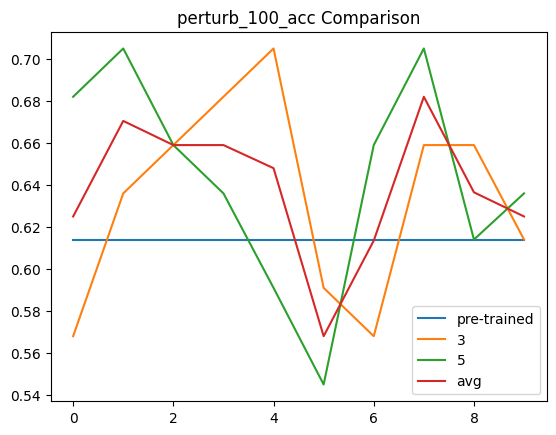

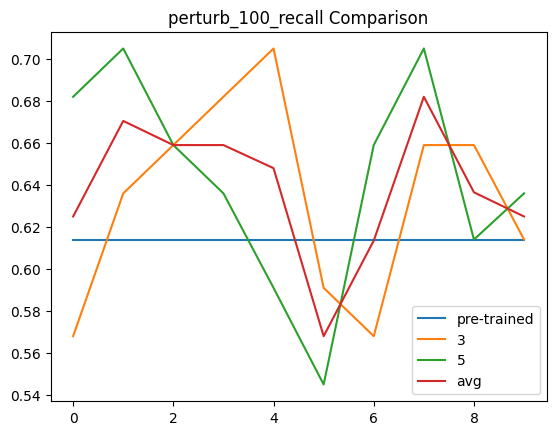

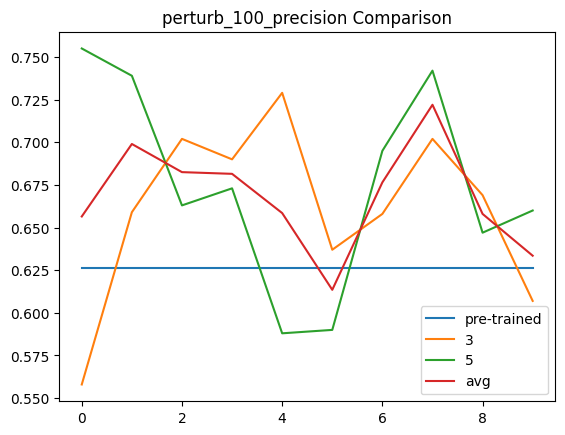

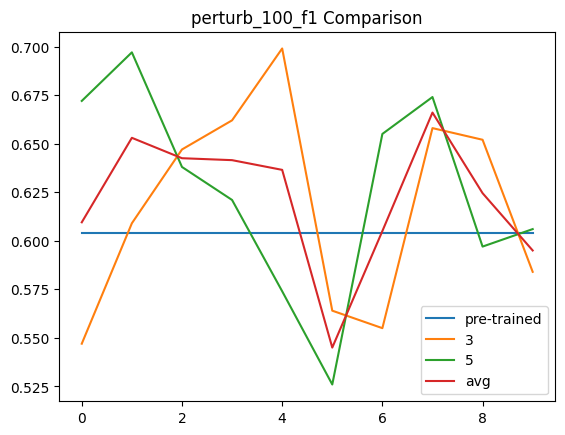

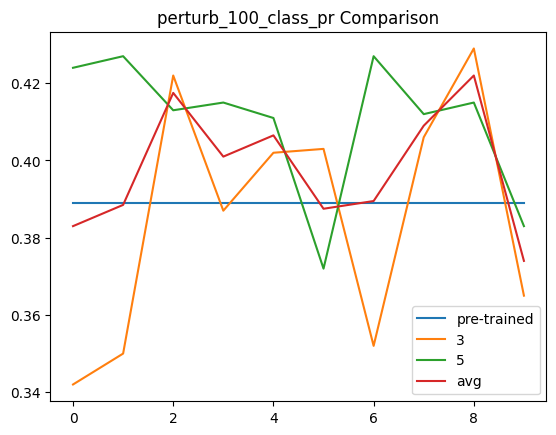

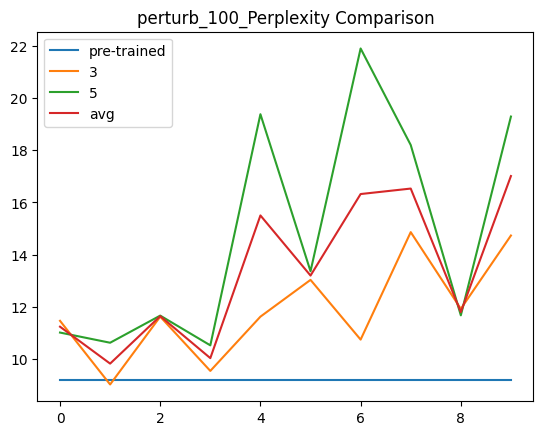

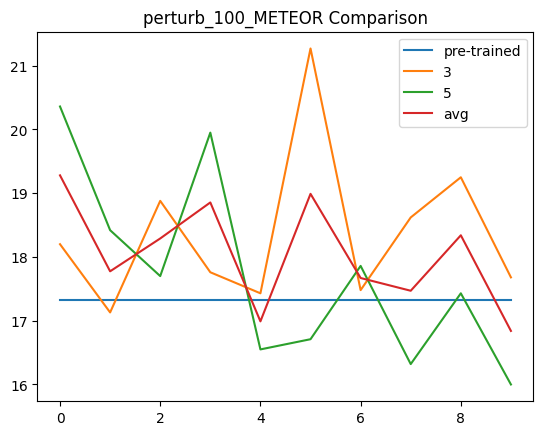

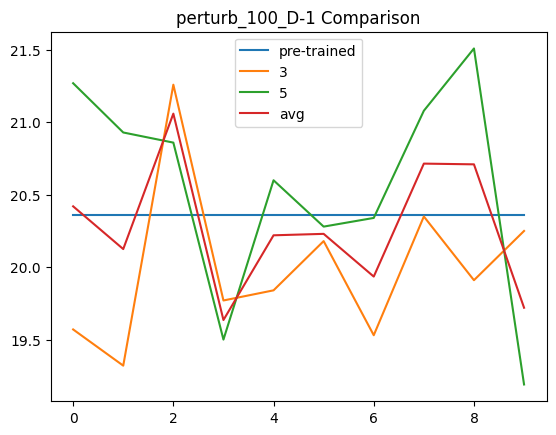

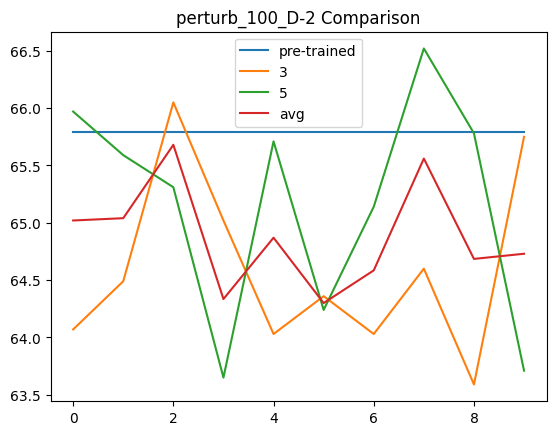

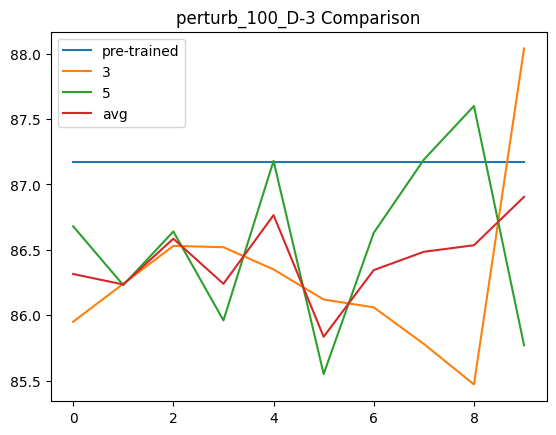

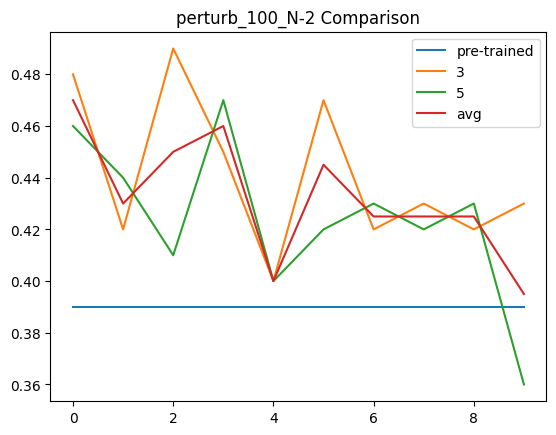

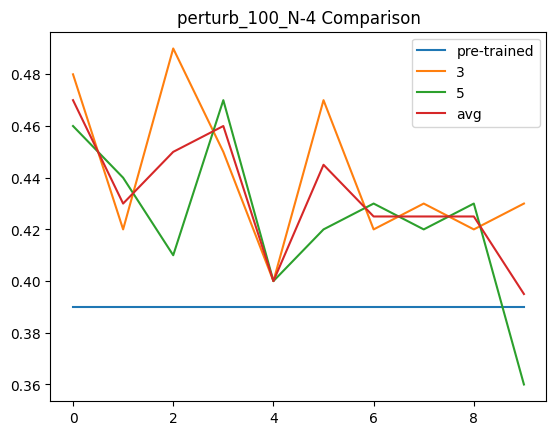

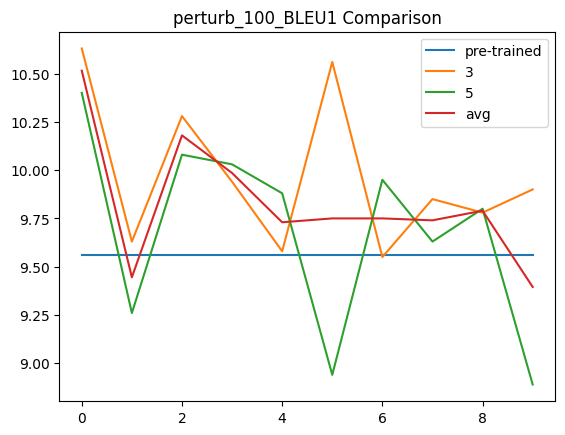

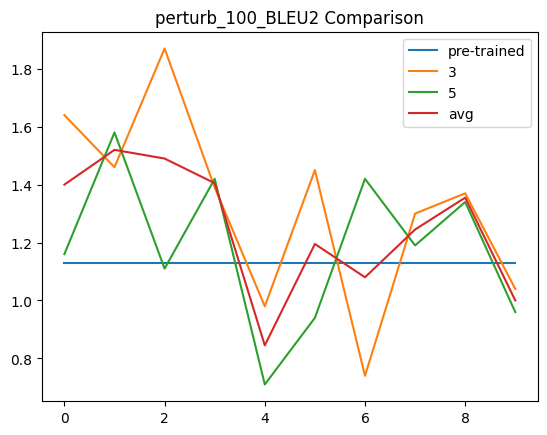

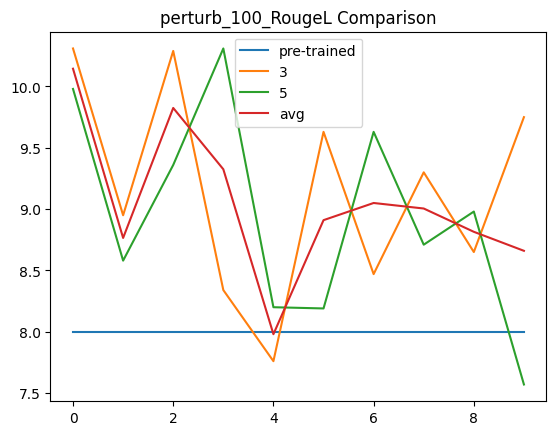

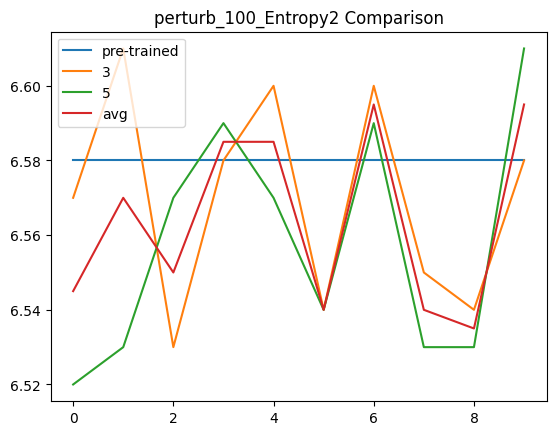

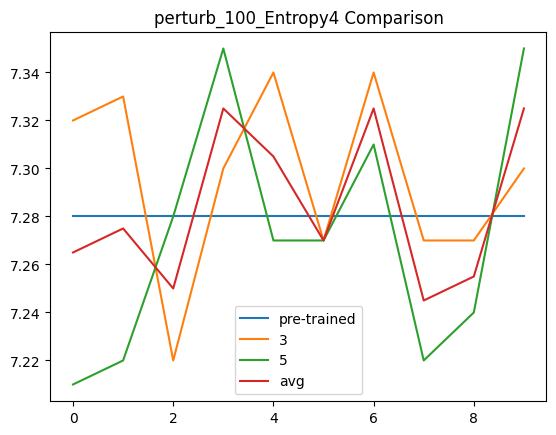

In [17]:
def plot_re(df,df_name,attribute):
    t1 = range(len(df[0]))
    plt.plot(t1,[not_perturb[attribute][0]]*len(df[0]),label ='pre-trained')
    for i,i_df in enumerate(df):
        plt.plot(t1,i_df[attribute],
                 label =df_name[i]
                )
    plt.legend()
    plt.title('perturb_100_{} Comparison'.format(attribute))
    plt.show()
for i in new_columns:
    plot_re([df_100_3,df_100_5,df_100_35],[3,5,'avg'],i)

# test_notebook

In [7]:
def slice_until_last_punctuation(text):
    punctuation_indices = [i for i, char in enumerate(text) if char in ('.', '?', '!')]
    last_punctuation_index = punctuation_indices[-1] if punctuation_indices else -1
    return text[:last_punctuation_index + 1]

sentence = """Oh, great! 🙌🏼 Sure thing! ⌛️

It'll take us around 4-5 hours to drive from Brighton to London, depending on traffic and the route we take. 🚗💨

Would you like to stop for a"""
sliced_sentence = slice_until_last_punctuation(sentence)
print(sliced_sentence)

Oh, great! 🙌🏼 Sure thing! ⌛️

It'll take us around 4-5 hours to drive from Brighton to London, depending on traffic and the route we take.


In [10]:
model_path ="meta-llama/Llama-2-7b-chat-hf"
tokenizer = LlamaTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token

In [97]:
from transformers import BertTokenizerFast, BertModel
from torch.utils.data import Dataset,DataLoader
import sklearn
from tqdm import tqdm
setting_name = '{}__{}__{}'.format(0.01,100,3)
class CustomDataset(Dataset):
    def __init__(self, df):
        self.data =df 
        self.data_list, self.label_list = self.load_data()
        
    def __len__(self):
        return len(self.label_list)
    def load_data(self):
        data_list = self.data['generated']
        label_list = self.data['act']
        
        return data_list, label_list 
    def __getitem__(self, index):
        data = self.data_list[index]
        label = torch.tensor(self.label_list[index], dtype = torch.long)
        return data, label

with open('results/'+setting_name+'.pickle', 'rb') as fr:
        data = pickle.load(fr)
data = data[data['act']!=2].reset_index(drop=True)

model = Model()
model = torch.load('/home/wooseok/orange/peft/dailydialogue/dialogpt/Bert_model/Bert_model_training/epoch10_bert_model.pt')
model.to(device)
model.eval()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
max_len= 500

df_data = data[['generated','act']]
df_data = df_data.sample(len(df_data)).reset_index(drop=True)
test_set = CustomDataset(df_data)
test_dl = DataLoader(test_set,batch_size=20, shuffle = False)    

test_acc = 0.0
test_n_samples = 0
predictions = torch.tensor([]).to(device)
ground_truths = torch.tensor([]).to(device) 
class_pr =torch.tensor([])
model.eval()
with torch.no_grad():
    for batch_idx,batch in enumerate(tqdm(test_dl, ncols=80, desc='valid_step')):
        data, y_true = batch
        data = tokenizer(list(data), return_tensors='pt', padding=True, truncation=True)
        
        data = { k: v.to(device) for k, v in data.items() }
        y_true = y_true.to(device)
        y_pred = model(data)
        
        class_pr = torch.cat([class_pr,torch.tensor([row[true_value.item()] for row, true_value in zip(y_pred.softmax(1), y_true)])])
        pre_per = y_pred.argmax(1)
        for j in range(len(pre_per)):
            if pre_per[j] ==2:
                pre_per[j] = np.argsort(-y_pred[j].to('cpu'))[1]
        
        predictions = torch.cat([predictions,pre_per])
        ground_truths = torch.cat([ground_truths,y_true])
        
class_pr = round(torch.mean(class_pr).to('cpu').item(),3)
accuracy_score= round(sklearn.metrics.accuracy_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu')),3)
recall= round(sklearn.metrics.recall_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)
precision = round(sklearn.metrics.precision_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)
f1_score = round(sklearn.metrics.f1_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)

print(accuracy_score,recall,precision,f1_score,class_pr)
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truths.to('cpu'), predictions.to('cpu'))


valid_step: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 21.04it/s]

0.556 0.556 0.55 0.534 0.338


array([[ 7,  3,  5],
       [ 5,  5,  5],
       [ 0,  2, 13]])

In [95]:
ground_truths

tensor([1., 1., 3., 1., 3., 3., 3., 1., 0., 3., 0., 0., 1., 0., 3., 3., 0., 3.,
        1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 3., 3., 3., 1., 1., 0.,
        0., 0., 3., 1., 3., 3., 1., 3., 0.], device='cuda:0')

In [96]:
predictions

tensor([1., 1., 3., 3., 3., 3., 3., 1., 1., 1., 3., 1., 3., 3., 3., 3., 0., 3.,
        1., 0., 1., 3., 1., 0., 3., 1., 0., 1., 1., 3., 3., 3., 3., 3., 1., 0.,
        0., 0., 3., 3., 3., 3., 1., 3., 0.], device='cuda:0')

In [92]:
y_pred

tensor([[ 0.7317, -2.7256,  0.4813,  1.0399],
        [-1.5774, -1.4053,  1.3130,  0.5814],
        [-0.4481,  1.7627, -1.2857, -0.1768],
        [ 0.2852, -1.6927, -0.9015,  1.6761],
        [ 0.2746, -0.3298, -0.4644,  0.0251]], device='cuda:0')

In [93]:
y_pred.softmax(1)

tensor([[0.3154, 0.0099, 0.2455, 0.4292],
        [0.0347, 0.0412, 0.6240, 0.3002],
        [0.0843, 0.7687, 0.0365, 0.1105],
        [0.1831, 0.0253, 0.0559, 0.7357],
        [0.3567, 0.1949, 0.1704, 0.2780]], device='cuda:0')

In [68]:
pre_per = y_pred.argmax(1)
pre_per

tensor([3, 2, 1, 1, 2, 3, 1, 1, 2, 2, 3, 0, 1, 0, 3, 3, 0, 0, 0, 3],
       device='cuda:0')

In [71]:
pre_per[1] = 3
pre_per

tensor([3, 3, 1, 1, 2, 3, 1, 1, 2, 2, 3, 0, 1, 0, 3, 3, 0, 0, 0, 3],
       device='cuda:0')

In [72]:
y_pred

tensor([[-0.7153, -0.8462,  0.2107,  0.7076],
        [-1.2018, -1.0213,  0.9928,  0.4032],
        [-1.2252,  0.9010,  0.1212, -0.1408],
        [-0.4481,  1.7627, -1.2857, -0.1768],
        [-1.5854, -0.7354,  1.4314,  0.0581],
        [ 0.2852, -1.6927, -0.9015,  1.6761],
        [-1.5733,  1.4170,  0.4467, -0.7066],
        [-0.3676,  0.5230, -0.8266,  0.4917],
        [-1.7734,  0.1107,  1.2698, -0.0896],
        [-1.0396, -1.5939,  0.8745,  0.7558],
        [-0.2976, -0.9134,  0.2868,  0.5813],
        [ 2.4123, -2.1623, -1.5726,  0.8576],
        [-0.6304,  0.9049,  0.0425, -0.2481],
        [ 1.0997, -0.8881, -1.1317,  0.7076],
        [ 0.7317, -2.7256,  0.4813,  1.0399],
        [-0.0215, -1.2402, -0.2280,  0.8853],
        [ 2.5243, -2.1539, -1.4676,  0.8529],
        [ 1.1656, -1.4185, -0.9953,  0.8651],
        [ 1.6974, -1.1524, -0.8651,  0.3224],
        [-0.8582, -1.2882,  0.4377,  0.9689]], device='cuda:0')

In [89]:
pre_per

tensor([3, 3, 1, 1, 3, 3, 1, 1, 2, 2, 3, 0, 1, 0, 3, 3, 0, 0, 0, 3],
       device='cuda:0')

In [87]:
np.argsort(-y_pred[3].to('cpu'))[1]

tensor(3)

In [88]:
pre_per[4] = np.argsort(-y_pred[4].to('cpu'))[1]

In [79]:
y_pred[4].argmax()

tensor(2, device='cuda:0')

In [73]:
y_pred.argmax(1)

tensor([3, 2, 1, 1, 2, 3, 1, 1, 2, 2, 3, 0, 1, 0, 3, 3, 0, 0, 0, 3],
       device='cuda:0')

In [66]:
np.argsort(-y_pred.to('cpu'), axis=1)[:, 1]

tensor([2, 3, 3, 2, 1])

In [63]:
predictions

tensor([3., 3., 3., 2., 2., 0., 3., 3., 0., 1., 1., 2., 3., 1., 0., 2., 0., 1.,
        3., 1., 2., 3., 3., 2., 0., 3., 1., 2., 1., 3., 3., 3., 2., 2., 1., 0.,
        0., 1., 3., 1., 1., 1., 0., 3., 2.], device='cuda:0')

In [64]:
ground_truths

tensor([3., 3., 3., 3., 1., 0., 0., 3., 0., 1., 0., 3., 3., 1., 0., 1., 1., 1.,
        3., 1., 0., 0., 0., 3., 0., 1., 1., 3., 1., 3., 3., 1., 3., 0., 3., 0.,
        0., 1., 0., 1., 1., 0., 0., 3., 1.], device='cuda:0')

In [47]:
22/36

0.6111111111111112

In [37]:
class_pr.item()

NameError: name 'class_pr' is not defined

In [116]:
import sklearn
accuracy_score= round(sklearn.metrics.accuracy_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu')),3)
recall= round(sklearn.metrics.recall_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)
precision = round(sklearn.metrics.precision_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)
f1_score = round(sklearn.metrics.f1_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average='weighted'),3)


0.475

In [113]:
for i in  ['micro', 'macro', 'weighted']:
    
    print(precision)

0.475
0.477
0.475


In [114]:
for i in  ['micro', 'macro', 'weighted']:
    precision= round(sklearn.metrics.precision_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average=i),3)
    print(precision)

0.475
0.476
0.477


In [115]:
for i in  ['micro', 'macro', 'weighted']:
    precision= round(sklearn.metrics.f1_score(y_true=ground_truths.to('cpu'), y_pred=predictions.to('cpu'),average=i),3)
    print(precision)

0.475
0.471
0.47


In [ ]:
accuracy_score= round(sklearn.metrics.accuracy_score(y_true=np.array(val_targets), y_pred=val_preds, average =average),3)
precision= round(sklearn.metrics.precision_score(y_true=np.array(val_targets), y_pred=val_preds, average =average),3)
recall = round(sklearn.metrics.recall_score(y_true=np.array(val_targets), y_pred=val_preds, average =average),3)
f1 = round(sklearn.metrics.f1_score(y_true=np.array(val_targets), y_pred=val_preds, average =average),3)

In [72]:
import string
import random

In [89]:

letters_set = string.ascii_letters
random_list = random.sample(letters_set[26:],10)
print(random_list)

['K', 'X', 'C', 'Y', 'H', 'U', 'R', 'A', 'W', 'T']
